**PARTE 2**

###**Importación de librerias**

In [34]:
!pip install pyts

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import h5py
from google.colab import drive
from pyts.transformation import ShapeletTransform

from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/UNIVERSIDAD/SEMESTER 06/Machine Learning/P2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Funciones auxiliares**

In [38]:
def readH5File(filename):
  with h5py.File(path + filename, 'r') as f:
    x = f['x'][:]
    if 'y' in f:
      y = f['y'][:]
      return x, y
    return x

In [39]:
def confusionMatrix(y_pred, y_test, type_label):
  labels = ['no predisposition to alcoholism', 'predisposition to alcoholism']
  matrix = confusion_matrix(y_test, y_pred).astype('float')
  matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
  df_matrix = pd.DataFrame(matrix, index=labels, columns=labels)

  sns.heatmap(df_matrix, annot=True, cbar=False, cmap="Greens")
  plt.title("Confusion Matrix " + type_label)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.tight_layout()
  plt.show()

In [40]:
def getMetrics(y_test, y_pred):
  targets = ['no predisposition to alcoholism', 'predisposition to alcoholism']

  precision = precision_score(y_test, y_pred, average=None)
  f1 = f1_score(y_test, y_pred, average=None)

  report = classification_report(y_test, y_pred, target_names=targets)
  print("My Model Metrics:")
  print(report)

  results = {}
  for i, name in enumerate(targets):
    results[name] = {
      "Precision": precision[i],
      "F1-Score": f1[i]
    }

  return results

##**5. Modelos**

----
# **5.2. Soft SVM**
----

El modelo Soft SVM nos permite:

* **Clasificar datos no linealmente separables:** Maneja datos que no pueden ser separados perfectamente por un hiperplano lineal mediante la introducción de un margen suave y variables de holgura. Para este proyecto, se probaron varios kernels y el mejor resultado se obtuvo con el kernel lineal.

* **Manejar datos con ruido:** Gestiona mejor los conjuntos de datos con ruido o puntos atípicos, evitando el sobreajuste al permitir algunos errores de clasificación.

* **Controlar el balance entre margen y error:** El parámetro de regularización **C** ajusta el equilibrio entre maximizar el margen y minimizar el error de clasificación, proporcionando flexibilidad para adaptarse a diferentes conjuntos de datos. Este parámetro **C** fue usado en la función Loss para controlar el segundo terminno y también en la función Derivatives.

In [41]:
class SoftSVM:
  def __init__(self, alpha, C):
    self.alpha = alpha
    self.C = C
    self.w = None
    self.b = None

  def H(self, X):
    return np.dot(X, self.w.T) + self.b

  def Loss(self, y, y_aprox):
    return 0.5 * (np.linalg.norm(self.w) ** 2) + self.C * np.sum(np.maximum(0, 1 - y * y_aprox))

  def Derivatives(self, X, y, y_aprox):
    loss_matrix = 1 - y * y_aprox
    dw = self.w + self.C * np.sum(-y[:, np.newaxis] * X * (np.maximum(0, loss_matrix) > 0)[:, np.newaxis], axis=0)
    db = self.C * np.sum(-y * (np.maximum(0, loss_matrix) > 0))
    return db, dw

  def Update(self, dw, db):
    self.w = self.w - self.alpha * dw
    self.b = self.b - self.alpha * db
    return self.w, self.b

  def Train(self, X, y, epochs=1000):
    num_samples, num_features = X.shape
    self.w = np.zeros(num_features)
    self.b = 0
    error = []

    for i in range(epochs):
      y_aprox = self.H(X)
      db, dw = self.Derivatives(X, y, y_aprox)
      self.w, self.b = self.Update(dw, db)
      L = self.Loss(y, y_aprox)
      error.append(L)
    return self.w, self.b, error

  def Predict(self, X):
    return np.sign(self.H(X))

##Extracting features

Para este proyecto, hemos utilizado la técnica ROCKET para extraer características de una serie temporal, principalmente porque no es tan costosa computacionalmente y ofrece buenos resultados en la extracción de características. Cabe resaltar que también hemos probado otras opciones, como el uso de la librería TsFresh y la técnica ShapeletTransform, pero las descartamos por ser muy costosas computacionalmente. Además, probamos la técnica BOOS, pero esta tampoco ofreció resultados satisfactorios.

**ROCKET: Random Convolutional Kernel Transform**

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyts.transformation import ROCKET

A diferencia de otros métodos de extracción de características que tienen un alto costo computacional, este método nos ofrece una forma más sencilla y menos costosa de obtener características.

* Con ROCKET, transformamos las series temporales de entrada para la extracción de características mediante núcleos convolucionales aleatorios.

* Las convoluciones implican productos escalares deslizantes entre un núcleo convolucional y una serie temporal de entrada. La salida convolucional refleja la fuerza de la coincidencia entre el núcleo y la serie temporal de entrada en cada momento.

* La convolución representa un mecanismo para capturar diversas características en series temporales, lo que es la base de la eficacia de esta técnica.

* Esta técnica utiliza más de 10,000 núcleos convolucionales aleatorios, que varían en longitud, peso, sesgo, etc.

In [43]:
X, Y = readH5File('train.h5')
X_TEST = readH5File('test.h5')

X = X.squeeze(axis=1)
X_TEST = X_TEST.squeeze(axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Para poder utilizar el Soft SVM, tuvimos que cambiar las etiquetas 0 del array Y a -1. Sin embargo, al final del proceso, revertimos este cambio a sus valores originales.

In [44]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)
y_train_transformed = np.where(y_train == 0, -1, 1) # changed 0s to -1s
y_test_transformed = np.where(y_test == 0, -1, 1) # changed 0s to -1s

**Aplicamos ROCKET**

In [45]:
rocket = ROCKET()
rocket.fit(x_train_normalized)
x_train_transformed = rocket.transform(x_train_normalized)
x_test_transformed = rocket.transform(x_test_normalized)

**El parámetro alpha en la clase SoftSVM es la tasa de aprendizaje, un hiperparámetro que controla la magnitud de los ajustes realizados en los pesos (w) y el sesgo (b) durante el proceso de optimización. En el método Update, alpha se multiplica con los gradientes (dw y db) para actualizar los parámetros del modelo, determinando cuánto cambian estos parámetros en cada iteración del entrenamiento.**

**Por otro lado, C es el parámetro de penalización, también conocido como regularización. Controla la importancia de penalizar los errores de clasificación, permitiendo que el SVM maneje datos no linealmente separables. Este parámetro es usado en el cálculo de la pérdida (Loss) y las derivadas (Derivatives).**

In [46]:
svm = SoftSVM(alpha=0.00014, C=1e-3) #C=1e-3

In [47]:
W, b, err = svm.Train(x_train_transformed, y_train_transformed, epochs=1200) #1200

In [48]:
y_pred = svm.Predict(x_test_transformed)

In [49]:
print(y_pred, y_test_transformed)
print(W, b, err[-1])

[ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.
  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.
  1.  1.  1. -1. -1. -1. -1. -1.] [ 1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1]
[ 0.00058055 -0.00023701 -0.00071201 ... -0.00010886  0.00079703
 -0.00022406] -0.00024962000000000427 0.062320361492295764


##Classification Metrics

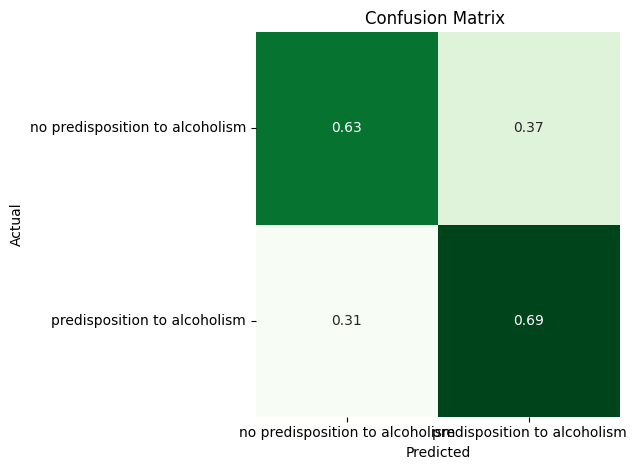

In [50]:
confusionMatrix(y_pred, y_test_transformed, type_label='')

In [51]:
results = getMetrics(y_test_transformed, y_pred)

My Model Metrics:
                                 precision    recall  f1-score   support

no predisposition to alcoholism       0.85      0.63      0.72        46
   predisposition to alcoholism       0.39      0.69      0.50        16

                       accuracy                           0.65        62
                      macro avg       0.62      0.66      0.61        62
                   weighted avg       0.73      0.65      0.67        62



**Prediction File for Kaggle**

In [ ]:
import pandas as pd

X_TEST_NORMALIZED = scaler.fit_transform(X_TEST)
X_TEST_TRANSFORMED = rocket.transform(X_TEST_NORMALIZED)
Y_PRED = svm.Predict(X_TEST_TRANSFORMED)
Y_PRED[Y_PRED == -1] = 0

df = pd.DataFrame({'ID': range(1, len(Y_PRED) + 1), 'result': Y_PRED.astype(int)})
df.to_csv('prediction.csv', index=False)